# Predicting MPG with SDC

**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Utilize characteristics from various cars to predict miles-per-gallon fuel consumption.  The prediction equation is determined using Stocastic Gradient Descent minimization method.

In [607]:
# CONSTANTS
DATASET_FILE = 'autompg_dataset.csv'
NUMBER_FOR_TRAINING = 200
NUMBER_FOR_VALIDATION = 100
OUTPUT_FEATURE='mpg'
INPUT_FEATURES=['horsepower', 'weight']
EPOCHS = 1000

In [608]:
# LIBRARIES
import numpy as np                  # matrix manipulation
import random                       # shuffle data
import matplotlib.pyplot as plt     # surface plot

In [609]:
# FUNCTIONS
# Create Augmented Design Matrix
def AugmentedDesignMatrix(dataSet, features):
    # Create the design matrix.
    adm = dataSet[features[0]]
    for feature in features[1:]:
        adm = np.column_stack((adm,dataSet[feature]))
     # Augment the design matrix to accomodate the bias term.
    adm = np.column_stack((adm,np.ones(len(adm))))
    return adm

In [610]:
# Calculate Mean Squared Error
def MSE(actual, predicted):
    return np.square(np.subtract(actual, predicted)).mean()

In [611]:
# Create a Prediciton Equation String
def PredictionEquation(y, xs, w):
    eq = '{} = '.format(y)
    wfmat = lambda i: ('+' if i > 0 else '') + '{:0.6}'.format(i)
    for idx, x in enumerate(xs):
        eq += '{}*{}'.format(wfmat(w[idx]), x)
    eq += wfmat(w[-1])
    return eq

In [612]:
# Perform Stochastic Gradient Decent on a Training Set
def StochasticGradientDecent(trainSet, valSet, outParam, inParam, epochs=1000,batchSize=1,etaMax=0.1, beta=1):
    trainMse = []
    Ytrain = trainSet[outParam]
    Xtrain = AugmentedDesignMatrix(dataSet=trainSet,features=inParam)

    valMse = []
    Yval = valSet[outParam]
    Xval = AugmentedDesignMatrix(dataSet=valSet,features=inParam)

    # Inialize the augmented weight vector with zeros.
    Wa = np.zeros(len(inParam)+1)

    # Determine the number of itterations needed.
    itters = round(len(trainSet)/batchSize)

    for e in range(epochs):
        for t in range(itters):
            # Parse out a sample of the training set for a batch.
            batchSet = trainSet[batchSize*t:batchSize*(t+1)]

            # Shuffle the batch.
            #random.shuffle(batchSet)
            # Note: This persists with each run and reorders the training set (not just batchSet for run).

            # Segregate out the output parameter values.
            Ybatch = batchSet[outParam]

            # Segregate out the values for the input parameters and augment it with ones for bias.
            Xbatch = AugmentedDesignMatrix(dataSet=batchSet,features=inParam)

            # Update the learning rate.
            eta = etaMax / (1 + (beta * t))

            # Calculate the sum of gradients.
            dE = 0
            for s in range(batchSize):
                dE += Xbatch[s].T.dot(Xbatch[s].dot(Wa)-Ybatch[s])
            g = (2/batchSize) * dE

            # Update the augmented weight vector.
            Wa -= eta * g

        # Append the training/validation MSE to a list.
        trainMse.append(MSE(Ytrain,Xtrain.dot(Wa)))
        valMse.append(MSE(Yval,Xval.dot(Wa)))

    return Wa, trainMse, valMse

In [613]:
def SgdPlot(trainMse,valMse,batchSize):
    plt.plot(trainMse,color='b',label='Training MSE')
    plt.plot(valMse,color='r',label='Validation MSE')
    plt.yscale('log')
    plt.xlabel('MSE')
    plt.ylabel('Epoch')
    plt.legend()
    plt.title('MSE per Epoch for Batch Size of {}'.format(batchSize))
    plt.show()

In [614]:
# Load data file
csvFile = open(DATASET_FILE, 'r')
dataSet = np.genfromtxt(csvFile, delimiter=',', names=True, case_sensitive=True)
csvFile.close()

In [615]:
# Split the data set into groups for training, validation and test.
trainData = dataSet[:NUMBER_FOR_TRAINING]
valData = dataSet[NUMBER_FOR_TRAINING+1:NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION]
testData = dataSet[NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION+1:]

## Part (a): Batch Size 1
Plot the training and validation MSE per epoch for a batch size of 1.

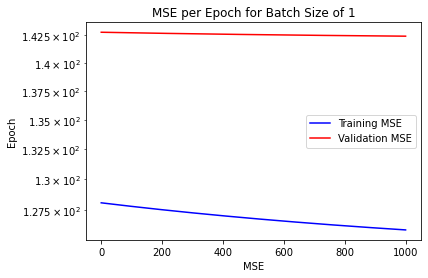

mpg = -0.0136254*horsepower+0.00664005*weight+0.00319717


In [616]:
PART_A_BATCH_SIZE = 1
Wa, trainMse, valMse = StochasticGradientDecent(trainSet=trainData, valSet=valData, outParam=OUTPUT_FEATURE, inParam=INPUT_FEATURES, epochs=EPOCHS,batchSize=PART_A_BATCH_SIZE,etaMax=2.0E-7, beta=1)
SgdPlot(trainMse=trainMse,valMse=valMse,batchSize=PART_A_BATCH_SIZE)
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))

### Observation
The maximum eta (i.e. learning rate) must be set very low or else, the model will diverge.  Tweeking eta and beta (i.e. learning decay rate), an MSE compariable to the OLS could not be achieved within 1000 epochs.  Also, the prediction equation was not near the OLS solution within the epoch limit.

## Part (b): Batch Size 20
Same as part a but with batch size of 20.

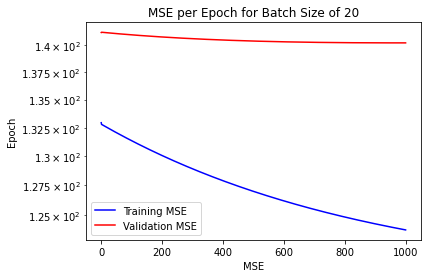

mpg = -0.0591763*horsepower+0.00832361*weight+0.00279277


In [617]:
PART_A_BATCH_SIZE = 20
Wa, trainMse, valMse = StochasticGradientDecent(trainSet=trainData, valSet=valData, outParam=OUTPUT_FEATURE, inParam=INPUT_FEATURES, epochs=EPOCHS,batchSize=PART_A_BATCH_SIZE,etaMax=2.0E-7, beta=1)
SgdPlot(trainMse=trainMse,valMse=valMse,batchSize=PART_A_BATCH_SIZE)
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))

### Observation
Higher batch size converges more quickly to a lower MSE.  On both batch size cases, the MSE for validation was not close to the training set.  This is expected since the weights/bias is being tuned only to the training set.  When the number of epochs was increased to 10,000, the MSE did decrease, but not by much.